# This script identifies LG analogues in the halo catalogue and extracts the merger tree data from the tree file, in preparation for plotting.

### Running this script requires the Mini-Uchuu z=0 halo catalog and merger tree files, which are available at skiesanduniverses.org.

Note that some steps take a lot of time (mostly due to reading files from disk). If you don't want to rerun them each time, skip those cells. This script is designed to save intermediate results to disk and read them from disk.

You are free to use any part of this script. If you use any of it in your own scientific work, we would appreciate a citation to our paper, by Sawala, Penarrubia, Liao and Johansson.

For any questions, please email: till.sawala@helsinki.fi, or contact me via github.

### Define path for local modules

This will depend on your particular environment and will not be necessary if you have all packages that are imported below in your standard python path.

In [1]:
import sys
print(sys.path)

sys.path.append('/users/sawalati/.local/lib/python3.10/site-packages')

print("now:", sys.path)


['/users/sawalati', '/CSC_CONTAINER/miniconda/envs/env1/lib/python310.zip', '/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10', '/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/lib-dynload', '', '/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages', '/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/IPython/extensions', '/users/sawalati/.ipython']
now: ['/users/sawalati', '/CSC_CONTAINER/miniconda/envs/env1/lib/python310.zip', '/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10', '/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/lib-dynload', '', '/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages', '/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/IPython/extensions', '/users/sawalati/.ipython', '/users/sawalati/.local/lib/python3.10/site-packages']


### Imports

In [2]:
import numpy as np
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
from scipy.stats import norm


from scipy.signal import savgol_filter   


import math

from scipy import optimize
from scipy.optimize import fsolve
from scipy import spatial

import heapq

import timeit
import glob
from tqdm import tqdm

import os
import pickle
import psutil

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value

print ("loaded modules")

loaded modules


### Parameters

In [3]:
# File for the z=0 LG data.
LG_data_file = 'new_MiniUchu_data_m200_pos_gravity_IDs_rgrav=5.npz'  # files selected by m200, includes the gravity calculation

LG_tree_file = 'new_MiniUchu_treedata_set.npz'

cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3, Tcmb0=2.725)

hubble = .6774

G = 4300700 # for M in units of 10^12
max_residual = 1e-4 # for the TA solution
bounds = [(1e-2, 2*np.pi)] # bounds on eta for slsqp solver

boxSize = 2000. / hubble * 1000. 

m_min = 0.5e12  # minimum mass for the haloes at z=0
m_max = 5.e12 # maximum mass for the haloes at z=0

# the pamameters below are for the pre-selection of LG analogues. We later define 'broad' and 'strict' subsets.

r_gravity = 5000. # this is the radius within which we look for haloes that dominate the gravitational force.
r_limit = 2000. # this is the radius within which we want no third object
r_max = 1000. # this is the maximum separation between the MW and M31.
r_min = 400. # this is the minimum separation between the MW and M31.
vr_max = 50
vr_min = -250
vt_max = 250

# These are the selection criteria we use later for the 'broad' and 'strict' subsets.
r_min_strict = .77 - .15
r_max_strict = .77 + .15
vr_min_strict = -110 - 30
vr_max_strict = -110 + 30
vt_max_strict = 60

r_min_broad = .77 - .3
r_max_broad = .77 + .3
vr_min_broad = -110 - 90
vr_max_broad = -110 + 90
vt_max_broad = 150  

snapshots = np.array([50,45,40,30,20,15,12])
particle_index = np.arange(0,len(snapshots))   # for indexing the particle data
tree_index = 50 - snapshots                    # for indexing the tree data

fine_index = np.arange(0,max(tree_index)+1)

print ("tree indices:", tree_index, "particle indices:", particle_index)
print ("fine index:", fine_index)

# ages to display
ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1])*u.Gyr
ageticks = [1 / (1 + z_at_value(cosmo.age, age)) for age in ages]

# redshifts to display 
label_redshifts = np.array([4,3,2,1,0.5,0.2,0])
label_redshifts_str = ["4","3","2","1","0.5","0.2","0"]
label_scales = 1 / (label_redshifts + 1)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


m_min_gravity = 0.2e12 # consider perturbers above 2 x 10^11

N_volumes = 1 # For Mini-Uchuu, there is only one file

basePath = '/scratch/pjohanss/sawalati/mini_uchuu_halos/'

tree indices: [ 0  5 10 20 30 35 38] particle indices: [0 1 2 3 4 5 6]
fine index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


In [4]:
### Custom Functions

In [5]:
# We solve the eta equation, and then calculate a, M_TA and e.

# solve to obtain eta from t, r, vr, vt
def EtaEquation(eta, *data):
    r, vr, vt, t = data

    c = vt**2 / vr**2
    eqn = t * vr / r - np.sin(eta) * ( eta * (c * np.sin(eta)*np.sin(eta) + 1)**.5 - np.sin(eta)) / (np.cos(eta) - (c * np.sin(eta) * np.sin(eta) + 1)**.5)**2
    
    eqn = np.abs(eqn)
    
    return eqn


# The full TA equations, only used to check results
def TAequations(variables, *data):
    
    r, vr, vt, t = data[0]
    G = 4300700 # for M in units of 10^12
    
    a, e, eta, M = variables
    
    a = a * 1000 # to have a in Mpc
    
    eqn_1 = (a * (1. - e * np.cos(eta) ) - r) 
    eqn_2 = ( (a**3 / (G * M) )**.5 * (eta - e * np.sin(eta) ) - t ) 
    eqn_3 = ((G * M) / a)**.5 * e * np.sin(eta)  / (1. - e * np.cos (eta) + 1.e-12) - vr
    eqn_4 = ((G * M) / a)**.5 * (1. - e**2)**.5 / (1. - e * np.cos(eta) + 1.e-12) - vt
    return [eqn_1, eqn_2, eqn_3, eqn_4]


def evalTA(p, *data): # evaluate the general TA given the parameters and the data
    return abs(sum(np.array(TAequations(p, data))**2))




### Read the Uchuu scale factors

In [6]:
f = open('Uchuu_redshift_scalefactors.txt', 'r')

lines = f.readlines()
scale = []
                  
for line in lines:
    columns = line.split()
    scale.append(float(columns[2]))

scale = np.flip(scale)
print ("scalefactors:", scale)

scalefactors: [0.999887 0.977848 0.956412 0.914941 0.87523  0.837539 0.801034 0.766456
 0.733135 0.701575 0.671151 0.642035 0.614153 0.587537 0.562099 0.537713
 0.514356 0.49213  0.470773 0.450389 0.430727 0.412155 0.394333 0.377182
 0.360886 0.34528  0.330255 0.315864 0.30214  0.289175 0.276536 0.264684
 0.253086 0.242223 0.231799 0.216898 0.202878 0.189856 0.177649 0.162519
 0.148772 0.136158 0.124496 0.113967 0.104325 0.095413 0.087363 0.079949
 0.073131 0.066964]


### Read the halo catalogue.
#### This is done in addition to the tree file, as it contains the tidal information. 

In [7]:
files = glob.glob(basePath+'MiniUchuu_halolist_*z0p00*')

files = np.sort(files)

print ("files:", files)

for i in range(N_volumes):

    print ("i:", i)
    hf = h5py.File(files[i], 'r')

    Datasetnames=hf.keys()                                                                                                                                              
    print (Datasetnames)                                                                                                                                                

    x = np.array( hf['x']) / hubble * 1000. # get coordinates in kpc
    y = np.array( hf['y']) / hubble * 1000.
    z = np.array( hf['z']) / hubble * 1000.

    m200 = np.array( hf['M200c']) / hubble # get physical masses

    print ("i:", i, "N:", len(x) )

    vx = np.array( hf['vx']) # velocities are physical 
    vy = np.array( hf['vy'])
    vz = np.array( hf['vz'])

    pos = np.array([x, y, z])
    vel = np.array([vx, vy, vz])

    pid = np.array(hf['pid'])
    ID = np.array(hf['id'])

    TidalID = np.array(hf['Tidal_ID'])

    hf.close()

    vel = vel.T
    pos = pos.T
    
print ("done reading halo catalogue")

files: ['/scratch/pjohanss/sawalati/mini_uchuu_halos/MiniUchuu_halolist_z0p00.h5']
i: 0
<KeysViewHDF5 ['A_x', 'A_x_500c', 'A_y', 'A_y_500c', 'A_z', 'A_z_500c', 'Acc_Rate_100Myr', 'Acc_Rate_1_Tdyn', 'Acc_Rate_2_Tdyn', 'Acc_Rate_Inst', 'Acc_Rate_Mpeak', 'Acc_Scale', 'Breadth_first_ID', 'Depth_first_ID', 'First_Acc_Mvir', 'First_Acc_Scale', 'First_Acc_Vmax', 'Future_merger_MMP_ID', 'Halfmass_Radius', 'Halfmass_Scale', 'Jx', 'Jy', 'Jz', 'Last_mainleaf_depthfirst_ID', 'Last_progenitor_depthfirst_ID', 'Log_Vmax_Vmax_max_Tdyn_Tmpeak_', 'M200b', 'M200c', 'M2500c', 'M500c', 'M_pe_Behroozi', 'M_pe_Diemer', 'Macc', 'Mpeak', 'Mpeak_Scale', 'Mvir', 'Mvir_all', 'Next_coprogenitor_depthfirst_ID', 'Orig_halo_ID', 'Rs_Klypin', 'Rvir', 'Snap_num', 'Spin', 'Spin_Bullock', 'T_U', 'Tidal_Force', 'Tidal_Force_Tdyn', 'Tidal_ID', 'Time_to_future_merger', 'Tree_root_ID', 'Vacc', 'Vmax_Mpeak', 'Voff', 'Vpeak', 'Xoff', 'b_to_a', 'b_to_a_500c', 'c_to_a', 'c_to_a_500c', 'desc_id', 'desc_pid', 'desc_scale', 'id', '

### Find pairs in the halo catalogue

In [8]:
print ("ID > 0", len(TidalID[ID > 0]))
print ("TidalID > 0", len(TidalID[TidalID > 0]))
print ("TidalID < 0", len(TidalID[TidalID < 0]))


# Select subhalo samples

totNum = len(m200)

print ("total number of halos:", totNum)

selectIndex = np.full(totNum, False)
selectIndex[m200 > m_min] = True
selectIndex[m200 > m_max] = False

selectNum = len(m200[selectIndex])

print('Number of selected halos:', selectNum)

print('Minimum mass:', min(m200[selectIndex]) / 1.e12, ' x 10^12' )
print('Maximum mass:', max(m200[selectIndex]) / 1.e12, ' x 10^12' )

gravityIndex = np.full(totNum, False)
gravityIndex[m200 > m_min] = True

gravityNum = len(m200[gravityIndex])

print('Number of gravity halos:', gravityNum)

# First, the accelerations
allPos = pos[gravityIndex]
allVel = vel[gravityIndex]
allm200 = m200[gravityIndex]

print ("Building tree...")

allPos = allPos.T
for i in range(3):
    allPos[i][allPos[i] >= boxSize] = allPos[i][allPos[i] >= boxSize] - boxSize
    allPos[i][allPos[i] < 0.0] = allPos[i][allPos[i] < 0.0] + boxSize

allPos = allPos.T
tree = spatial.cKDTree(allPos, boxsize=boxSize)

selectPos = pos[selectIndex]
selectm200 = m200[selectIndex]

print ("Tree built.")

# We calculate the max. gravity acceleration in a separate loop, so we know them for both haloes by the time we look for pairs.

MaxAcceleration = np.zeros(selectNum, dtype='float')

print ("Computing Max Accelerations")

for i in tqdm(range(selectNum)):
    GravityNeighbourList = tree.query_ball_point(selectPos[i], r_gravity)

    Accelerations = []

    for j in range (len(GravityNeighbourList)):

        r2 = (selectPos[i][0] - allPos[GravityNeighbourList[j]][0] )**2. + (selectPos[i][1] - allPos[GravityNeighbourList[j]][1] )**2. + (selectPos[i][2] - allPos[GravityNeighbourList[j]][2] )**2.

        if r2 > 0.000001:  # exclude the halo itself.
            Accelerations.append(allm200[GravityNeighbourList[j]] / r2)

        if len(Accelerations) > 1:
            MaxAcceleration[i] = heapq.nlargest(2, Accelerations)[1]         # the second highest acceleration in the list.
        else:
            MaxAcceleration[i] = 1.e-6

# Now, the LG identification

print ("Finding pairs")

LG_r = []
LG_vr = []
LG_vt = []
LG_M_MW = []
LG_M_M31 = []

LG_center = []

LG_pos_MW = []
LG_pos_M31 = []

LG_ID_MW = []
LG_ID_M31 = []

LG_TidalID_MW = []
LG_TidalID_M31 = []

LG_ForceRatio_MW = []
LG_ForceRatio_M31 = []

Number_Neighbours = np.zeros(selectNum, dtype='float64')

allPos = pos[selectIndex]
allVel = vel[selectIndex]

Number_pairs = 0

print ("Building tree...")

allPos = allPos.T
for i in range(3):
    allPos[i][allPos[i] >= boxSize] = allPos[i][allPos[i] >= boxSize] - boxSize
    allPos[i][allPos[i] < 0.0] = allPos[i][allPos[i] < 0.0] + boxSize

allPos = allPos.T
tree = spatial.cKDTree(allPos, boxsize=boxSize)

selectPos = pos[selectIndex]
selectVel = vel[selectIndex]
selectm200 = m200[selectIndex]

selectID = ID[selectIndex]
selectTidalID = TidalID[selectIndex]


print ("Tree built.")


for i in tqdm(range(selectNum)):

    FarNeighbourList = tree.query_ball_point(selectPos[i], r_limit)
    CloseNeighbourList = tree.query_ball_point(selectPos[i], r_min)   # we subtract these from the FarNeighborList,
                                                                                # to get the objects in the shell
    Number_Neighbours[i] = len(FarNeighbourList)
    
    if Number_Neighbours[i] > 1:
        allNeighbourList = [x for x in FarNeighbourList if x not in CloseNeighbourList]
        Number_Neighbours[i] = len(allNeighbourList)

        if Number_Neighbours[i] == 1:
            Neighbour = allNeighbourList[0]
            if i < Neighbour:                
                radius =  np.sqrt ((selectPos[i][0] - allPos[Neighbour][0] )**2. +
                                   (selectPos[i][1] - allPos[Neighbour][1] )**2. +
                                   (selectPos[i][2] - allPos[Neighbour][2] )**2. )
                
                vtot =  np.sqrt ((selectVel[i][0] - allVel[Neighbour][0] )**2. +
                                 (selectVel[i][1] - allVel[Neighbour][1] )**2. +
                                 (selectVel[i][2] - allVel[Neighbour][2] )**2. ) 
                
                vr = ((selectVel[i][0] - allVel[Neighbour][0]) * (selectPos[i][0] - allPos[Neighbour][0]) + 
                      (selectVel[i][1] - allVel[Neighbour][1] ) * (selectPos[i][1] - allPos[Neighbour][1]) + 
                      (selectVel[i][2] - allVel[Neighbour][2] ) * (selectPos[i][2] - allPos[Neighbour][2])) / radius
                          
                vt = np.sqrt (vtot**2 - vr**2)
                
                vr = vr + radius / 1000 * 100 * hubble  # Add h * 100 km/s / Mpc to account for the hubble flow.
                
                LG_r.append(radius)
                LG_vr.append(vr)
                LG_vt.append(vt)
                                       
                LG_center.append([(selectPos[i][0] + allPos[Neighbour][0]) * .5,
                                 (selectPos[i][1] + allPos[Neighbour][1]) * .5,
                                 (selectPos[i][2] + allPos[Neighbour][2]) * .5] )
                
                Number_pairs = Number_pairs + 1
                
                if selectm200[i] < selectm200[Neighbour] :
                    idx_MW = i
                    idx_M31 = Neighbour
                
                else:
                    idx_MW = Neighbour
                    idx_M31 = i
                
                LG_ForceRatio_MW.append(np.round(MaxAcceleration[i] / (selectm200[Neighbour] / radius**2.), 5))
                LG_ForceRatio_M31.append(np.round(MaxAcceleration[Neighbour] / (selectm200[i] / radius**2.), 5))
                
                LG_M_MW.append(selectm200[idx_MW])
                LG_M_M31.append(selectm200[idx_M31])
                    
                LG_pos_MW.append([selectPos[idx_MW][0], selectPos[idx_MW][1], selectPos[idx_MW][2]])
                LG_pos_M31.append([allPos[idx_M31][0], allPos[idx_M31][1], allPos[idx_M31][2]])
                    
                LG_ID_MW.append(selectID[idx_MW])
                LG_ID_M31.append(selectID[idx_M31])
               
                LG_TidalID_MW.append(selectTidalID[idx_MW])
                LG_TidalID_M31.append(selectTidalID[idx_M31])

                
# delete the tree
tree = 0
                    
# transform the lists to numpy array and remove objects that are not LG-like:
LG_r = np.array(LG_r)
LG_vr = np.array(LG_vr)
LG_vt = np.array(LG_vt)

LG_M_MW = np.array(LG_M_MW)
LG_M_M31 = np.array(LG_M_M31)

LG_center = np.array(LG_center)
LG_pos_MW = np.array(LG_pos_MW)
LG_pos_M31 = np.array(LG_pos_M31)

LG_ID_MW = np.array(LG_ID_MW)
LG_ID_M31 = np.array(LG_ID_M31)

LG_TidalID_MW = np.array(LG_TidalID_MW)
LG_TidalID_M31 = np.array(LG_TidalID_M31)

LG_ForceRatio_MW = np.array(LG_ForceRatio_MW)
LG_ForceRatio_M31 = np.array(LG_ForceRatio_M31)

indices = np.where( (LG_r > r_min) & (LG_r < r_max) & (LG_vr > vr_min) & (LG_vr < vr_max) & (LG_vt < vt_max) )[0]

LG_r = LG_r[indices]
LG_vr = LG_vr[indices]
LG_vt = LG_vt[indices]
LG_M_MW = LG_M_MW[indices]
LG_M_M31 = LG_M_M31[indices]

LG_ID_MW = LG_ID_MW[indices]
LG_ID_M31 = LG_ID_M31[indices]

LG_TidalID_MW = LG_TidalID_MW[indices]
LG_TidalID_M31 = LG_TidalID_M31[indices]

LG_ForceRatio_MW = LG_ForceRatio_MW[indices]
LG_ForceRatio_M31 = LG_ForceRatio_M31[indices]

LG_center =  LG_center[indices][:]
LG_pos_MW =  LG_pos_MW[indices][:]
LG_pos_M31 =  LG_pos_M31[indices][:]

Number_LG = len(indices)

# compute the LG centre and total mass:

LG_M_tot = LG_M_MW + LG_M_M31

print ("N pairs:", Number_pairs)
print ("N LG analogues:", Number_LG)

print ("done")

# Isolation criterion

selectIndex = np.full(totNum, False)
selectIndex[m200 > 1e13] = True

allPos = pos[selectIndex]

print ("len:", len(allPos), "constructing tree")

allPos = allPos.T
for i in range(3):
    allPos[i][allPos[i] >= boxSize] = allPos[i][allPos[i] >= boxSize] - boxSize
    allPos[i][allPos[i] < 0.0] = allPos[i][allPos[i] < 0.0] + boxSize
    
allPos = allPos.T
tree = spatial.cKDTree(allPos, boxsize=boxSize)

print ("tree construction done")

LG_N_sub = []

for i in range(len(indices)):
    NeighbourList = tree.query_ball_point(LG_center[i], 5000)
                                                                                # to get the objects in the shell
    Number_Neighbours = len(NeighbourList)
    LG_N_sub.append(Number_Neighbours)
    
LG_N_sub = np.array(LG_N_sub)

free = np.where (LG_N_sub == 0)[0]

# Compute tidal status

LG_TidalStatus = np.zeros(Number_LG, dtype=int)

for i in range (Number_LG):
    if (LG_TidalID_M31[i] == LG_ID_MW[i] or LG_TidalID_MW[i] == LG_ID_M31[i]):
        LG_TidalStatus[i] = 0
    else:
        LG_TidalStatus[i] = 1

# select LG analogues that are isolated, tidally dominant and with low force rations ("true LGs")  
        
selection_tidal = np.where(LG_TidalStatus == 0)[0]

print ("N free:", len(free))

print ("N tidal:", len(selection_tidal))

selection_force_MW = np.where(LG_ForceRatio_MW < 0.5)[0]
selection_force_M31 = np.where(LG_ForceRatio_M31 < 0.5)[0]

selection = list(set(selection_tidal) & set(selection_force_MW) & set (selection_force_M31) & set(free) )

print ("N true:", len(selection) )

print ("done identifying LG analogues")

ID > 0 33585418
TidalID > 0 33574429
TidalID < 0 10989
total number of halos: 33585418
Number of selected halos: 624110
Minimum mass: 0.500132860938884  x 10^12
Maximum mass: 4.999852376734573  x 10^12
Number of gravity halos: 702691
Building tree...
Tree built.
Computing Max Accelerations


100%|██████████| 624110/624110 [00:23<00:00, 26704.04it/s]


Finding pairs
Building tree...
Tree built.


100%|██████████| 624110/624110 [00:09<00:00, 65224.86it/s]


N pairs: 81234
N LG analogues: 14900
done
len: 38371 constructing tree
tree construction done
N free: 11786
N tidal: 13986
N true: 9657
done identifying LG analogues


In [9]:
print (len(selection))
print (len(LG_vr))

9657
14900


### Save z=0 data to file

In [10]:
print ("file:", LG_data_file)

file: new_MiniUchu_data_m200_pos_gravity_IDs_rgrav=5.npz


In [11]:
LG_r = LG_r[selection]
LG_vr = LG_vr[selection]
LG_vt = LG_vt[selection]
LG_M_MW = LG_M_MW[selection]
LG_M_M31 = LG_M_M31[selection]

LG_ID_MW = LG_ID_MW[selection]
LG_ID_M31 = LG_ID_M31[selection]

#print ("N:", len(LG_r))
print ("min MW mass", min(LG_M_MW) / 1.e12, ' x 10^12' )
print ("max MW mass", max(LG_M_MW) / 1.e12, ' x 10^12' )
print ("min M31 mass", min(LG_M_M31) / 1.e12, ' x 10^12' )
print ("max M31 mass", max(LG_M_M31) / 1.e12, ' x 10^12' ) 

np.savez(LG_data_file, allow_pickle = True,
         LG_ID_MW = LG_ID_MW, LG_ID_M31 = LG_ID_M31, LG_r = LG_r, 
         LG_vr = LG_vr, LG_vt = LG_vt, LG_M_MW = LG_M_MW, LG_M_M31 = LG_M_M31)

print ('done writing LG file')

min MW mass 0.500132860938884  x 10^12
max MW mass 4.743578387953941  x 10^12
min M31 mass 0.5030262769412459  x 10^12
max M31 mass 4.990256864481843  x 10^12
done writing LG file


### Read the LG data file back

In [12]:
data = np.load(LG_data_file)  # files selected by m200, includes the gravity calculation

print (list(data.keys()))

LG_ID_MW = data['LG_ID_MW']
LG_ID_M31 = data['LG_ID_M31']
LG_r = data['LG_r']
LG_vr = data['LG_vr']
LG_vt = data['LG_vt']
LG_M_MW = data['LG_M_MW']
LG_M_M31 = data['LG_M_M31']

Num_LG = len(LG_r)

print ("Num_LG", Num_LG)

print ('done reading LG file')

['allow_pickle', 'LG_ID_MW', 'LG_ID_M31', 'LG_r', 'LG_vr', 'LG_vt', 'LG_M_MW', 'LG_M_M31']
Num_LG 9657
done reading LG file


### Load the tree files.
#### In Mini-Uchuu, this is ascii, spread over 512 files.
#### On Puhti's file system, this takes around 90 minutes.

In [23]:
treefile_root = "/scratch/pjohanss/sawalati/mini_uchuu_mergertrees/MiniUchuu_"

treefiles = []

mass_threshold = m_min

for i in range(8):
    for j in range (8):
        for k in range (8):
            treefiles.append(treefile_root+str(i)+"_"+str(j)+"_"+str(k)+".trees" )
            
NFiles = len(treefiles)
            
NTrees = 0

print ("reading 512 tree files. This will take a while.")

for i, file in enumerate (tqdm(treefiles)):
    
    f = open(file, 'r')

    lines = f.readlines()[49:] # we skip the header

    NewTree = True

    for line in lines:

        columns = line.split()
    
        if len(columns) < 3  : # start of a new tree. Add haloes as long as the scale factor decreases along the main progenitor branch.
            
            NewTree = True
        
            if NTrees == 0:
                # First Tree. Initialising lists.
                ID_tree = []
                mass_tree = []
                x_tree = []
                y_tree = []
                z_tree = []
                vx_tree = []
                vy_tree = []
                vz_tree = []
                snapnum_tree = []

            else:  # This is not the first tree. It's time to add the last tree to the list.

                # To save memory, we only append if the z=0 mass is above the threshold for MW / M31 analogues.
                if mass[0] > mass_threshold * hubble:
                
                    ID = np.array(ID)
                    mass = np.array(mass)
                    x = np.array(x)
                    y = np.array(y)
                    z = np.array(z)
                    vx = np.array(vx)
                    vy = np.array(vy)
                    vz = np.array(vz)
                    snapnum = np.array(snapnum)

                    ID_tree.append(ID)
                    mass_tree.append(mass)
                    x_tree.append(x)
                    y_tree.append(y)
                    z_tree.append(z)
                    vx_tree.append(vx)
                    vy_tree.append(vy)
                    vz_tree.append(vz)
                    snapnum_tree.append(snapnum)

            NTrees = NTrees + 1

        else:

            if NewTree == False:
                if int(columns[34]) == LastProgID: # this halo is from the main progenitor branch

                # print ("snap:", snap)
                    ID.append(int(columns[1]))
                    mass.append(float(columns[10]))
                    x.append(float(columns[17]))
                    y.append(float(columns[18]))
                    z.append(float(columns[19]))
                    vx.append(float(columns[20]))
                    vy.append(float(columns[21]))
                    vz.append(float(columns[22]))
                    snapnum.append(float(columns[31]))

            if NewTree == True:

                LastProgID = int(columns[34])
                # Initialise arrays:
                ID = [int(columns[1])]
                mass = [float(columns[10])]
                x = [float(columns[17])]
                y = [float(columns[18])]
                z = [float(columns[19])]
                vx = [float(columns[20])]
                vy = [float(columns[21])]
                vz = [float(columns[22])]
                snapnum = [float(columns[31])]

                NewTree = False

    f.close
    
print ("all done")


reading 512 tree files. This will take a while.


100%|██████████| 8/8 [01:26<00:00, 10.87s/it]

all done


In [28]:
ID_z0 = [int(ID_tree[i][0]) for i in range(len(ID_tree))]
NTrees = len(ID_z0)

print ("NTrees:", NTrees)
print("Memory used", psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2, " MB")

NTrees: 806031
Memory used 8317.42578125  MB


### save raw tree data to file

In [17]:
raw_tree_file = 'rawtree.npz'

np.savez(raw_tree_file, allow_pickle = True,
         ID_tree = ID_tree, snapnum_tree = snapnum_tree,
         x_tree = x_tree, y_tree = y_tree, z_tree = z_tree,
         vx_tree = vx_tree, vy_tree = vy_tree, vz_tree = vz_tree,
         mass_tree = mass_tree)

print ("saved raw tree file")

saved raw tree file


### read the raw tree data back

In [60]:
raw_tree_file = 'rawtree.npz'

data = np.load(raw_tree_file, allow_pickle=True)  # files selected by m200, includes the gravity calculation

print (list(data.keys()))

ID_tree = data['ID_tree']
snapnum_tree = data['snapnum_tree']
x_tree = data['x_tree']
y_tree = data['y_tree']
z_tree = data['z_tree']
vx_tree = data['vx_tree']
vy_tree = data['vy_tree']
vz_tree = data['vz_tree']
mass_tree = data['mass_tree']

ID_z0 = [int(ID_tree[i][0]) for i in range(len(ID_tree))]

print ('done reading raw tree file')

['allow_pickle', 'ID_tree', 'snapnum_tree', 'x_tree', 'y_tree', 'z_tree', 'vx_tree', 'vy_tree', 'vz_tree', 'mass_tree']
done reading raw tree file


In [64]:
print ("len", len(ID_tree))


len 806031


### Select only the subset of trees that belong to LG analogues.

In [65]:
# identify the trees that match the z=0 IDs of the MW and M31    
test, indices_ID_MW, indices_tree_ID_MW  = np.intersect1d(LG_ID_MW, ID_z0, assume_unique=False, return_indices=True)
test, indices_ID_M31, indices_tree_ID_M31  = np.intersect1d(LG_ID_M31, ID_z0, assume_unique=False, return_indices=True)

# Check that both are found (intersection)
indices_both = np.intersect1d(indices_ID_MW, indices_ID_M31, assume_unique=False)
    
N_LG = len(indices_both)

print ("MWs matched to the tree file:  ", len(indices_ID_MW))
print ("M31s matched to the tree file:", len(indices_ID_M31))
print ("both members matched to the tree file:", N_LG)

# select the trees that contain either the MW or M31 (union)
selection = [*indices_tree_ID_MW, *indices_tree_ID_M31]
    
print ("len of selection:", len(selection))

MWs matched to the tree file:   9657
M31s matched to the tree file: 9657
both members matched to the tree file: 9657
len of selection: 19314


In [66]:
# identify the trees that match the z=0 IDs of the MW and M31    
test, indices_ID_MW, indices_tree_ID_MW  = np.intersect1d(LG_ID_MW, ID_z0, assume_unique=False, return_indices=True)
test, indices_ID_M31, indices_tree_ID_M31  = np.intersect1d(LG_ID_M31, ID_z0, assume_unique=False, return_indices=True)

# Check that both are found (intersection)
indices_both = np.intersect1d(indices_ID_MW, indices_ID_M31, assume_unique=False)

N_LG = len(indices_both)
print ("N LG matched to the trees:", N_LG)

# select the trees that contain either the MW or M31 (union)
selection = [*indices_tree_ID_MW, *indices_tree_ID_M31]

print ("len of selection:", len(selection))

# restrict the trees to only those corresponding to a MW or M31 progenitor

NTrees = len(selection)
ID_tree = [ID_tree[i] for i in selection]
snapnum_tree = [snapnum_tree[i] for i in selection]

x_tree = [x_tree[i] for i in selection]
y_tree = [y_tree[i] for i in selection]
z_tree = [z_tree[i] for i in selection]

vx_tree = [vx_tree[i] for i in selection]
vy_tree = [vy_tree[i] for i in selection]
vz_tree = [vz_tree[i] for i in selection]

mass_tree = [mass_tree[i] for i in selection]

ID_z0 = [int(ID_tree[i][0]) for i in range(NTrees)]

print ("NTrees:", NTrees)

# calculate the indices

index_MW = []
index_M31 = []

for i in range (N_LG):

    ID_MW = LG_ID_MW[indices_both[i]] # the ID of the MW
    ID_M31 = LG_ID_M31[indices_both[i]] # the ID of M31
   
    index_MW.append(int(np.where(ID_z0 == ID_MW)[0]))    # get a single scalar
    index_M31.append(int(np.where(ID_z0 == ID_M31)[0]))

print ("done")

N LG matched to the trees: 9657
len of selection: 19314
NTrees: 19314


### Save the matched trees to file

In [13]:
matched_tree_file = 'matched_tree.npz'

np.savez(matched_tree_file, allow_pickle = True,
         ID_tree = ID_tree, snapnum_tree = snapnum_tree,
         x_tree = x_tree, y_tree = y_tree, z_tree = z_tree,
         vx_tree = vx_tree, vy_tree = vy_tree, vz_tree = vz_tree,
         mass_tree = mass_tree, index_MW = index_MW, index_M31 = index_M31)

print ("saved matched tree file")

NameError: name 'ID_tree' is not defined

### Read the matched trees back

In [14]:
matched_tree_file = 'matched_tree.npz'

data = np.load(matched_tree_file, allow_pickle=True)  # files selected by m200, includes the gravity calculation

print (list(data.keys()))

ID_tree = data['ID_tree']
snapnum_tree = data['snapnum_tree']
x_tree = data['x_tree']
y_tree = data['y_tree']
z_tree = data['z_tree']
vx_tree = data['vx_tree']
vy_tree = data['vy_tree']
vz_tree = data['vz_tree']
mass_tree = data['mass_tree']
index_MW = data['index_MW']
index_M31 = data['index_M31']

ID_z0 = [int(ID_tree[i][0]) for i in range(len(ID_tree))]

NTrees = len(ID_tree)
N_LG = len(index_MW)

['allow_pickle', 'ID_tree', 'snapnum_tree', 'x_tree', 'y_tree', 'z_tree', 'vx_tree', 'vy_tree', 'vz_tree', 'mass_tree', 'index_MW', 'index_M31']


### calculate the fraction of haloes and pairs for which progenitors exist to snap 12.


In [15]:
N_prog_MW = np.array(list(len(snapnum_tree[index_MW[i]]) for i in range(N_LG)))
N_prog_M31 = np.array(list(len(snapnum_tree[index_M31[i]]) for i in range(N_LG)))

selection_MW = np.where(N_prog_MW > 38)[0]
selection_M31 = np.where(N_prog_M31 > 38)[0]

selection = list (set(selection_MW) & set(selection_M31))

#print (snapnum_tree[index_MW[selection_MW[0:100]]])

print ("len sel MW", len(selection_MW))
print ("len sel M31", len(selection_M31))
print ("len sel", len(selection))

print ("fraction MW matched", len(selection_MW) / N_LG)
print ("fraction M31 matched", len(selection_M31) / N_LG)
print ("fraction both matched", len(selection) / N_LG)

len sel MW 9029
len sel M31 9171
len sel 8583
fraction MW matched 0.9349694522108315
fraction M31 matched 0.9496738117427772
fraction both matched 0.8887853370611991


### run savgol filters on the orbits, select LG analogues that match the broad criteria, and compute the TA values.

This takes around 15 minutes on puhti. There may be some warnings from the optimisation.

In [16]:
list_M_TA = []
list_a_TA = []
list_e_TA = []
list_eta_TA = []
list_solver_TA = []

list_M_MW = []
list_M_M31 = []

list_r = []
list_vr = []
list_vt = []

list_N_prog = []

list_index_MW = []
list_index_M31 = []

list_x_MW = []
list_y_MW = []
list_z_MW = []

list_x_M31 = []
list_y_M31 = []
list_z_M31 = []

selection = []  # which of the LG analogues will contain a calculated orbit

N_solved = 0
N_try = 0

for i in tqdm(range(N_LG)): #range(N_LG)): # N_LG
    
    # count the number of progenitors:
    N_prog_MW = len(snapnum_tree[index_MW[i]])
    N_prog_M31 = len(snapnum_tree[index_M31[i]])
    
    N_prog = min(N_prog_MW, N_prog_M31)
        
    # extract the data from the tree.
    # do the calculations in physical coordinates.
    
    x_MW = x_tree[index_MW[i]][0:N_prog] * scale[0:N_prog] / hubble
    y_MW = y_tree[index_MW[i]][0:N_prog] * scale[0:N_prog] / hubble
    z_MW = z_tree[index_MW[i]][0:N_prog] * scale[0:N_prog] / hubble
    
    x_M31 = x_tree[index_M31[i]][0:N_prog] * scale[0:N_prog] / hubble
    y_M31 = y_tree[index_M31[i]][0:N_prog] * scale[0:N_prog] / hubble
    z_M31 = z_tree[index_M31[i]][0:N_prog] * scale[0:N_prog] / hubble
    
    vx_MW = vx_tree[index_MW[i]][0:N_prog] 
    vy_MW = vy_tree[index_MW[i]][0:N_prog] 
    vz_MW = vz_tree[index_MW[i]][0:N_prog] 
    
    vx_M31 = vx_tree[index_M31[i]][0:N_prog] 
    vy_M31 = vy_tree[index_M31[i]][0:N_prog] 
    vz_M31 = vz_tree[index_M31[i]][0:N_prog] 
     
    radius =  np.sqrt ((x_MW - x_M31 )**2. + (y_MW - y_M31 )**2. + (z_MW - z_M31 )**2.)

    vtot =  np.sqrt ((vx_MW - vx_M31 )**2. + (vy_MW - vy_M31 )**2. + (vz_MW - vz_M31 )**2.)

    vr = ( (vx_MW - vx_M31) * (x_MW - x_M31) +  (vy_MW - vy_M31) * (y_MW - y_M31) +  (vz_MW - vz_M31) * (z_MW - z_M31) ) / radius

    vt = np.sqrt (vtot**2 - vr**2)

    Hubble_flow = cosmo.H(1/scale[0:N_prog] - 1).value

    vr = vr + radius * Hubble_flow
    
    # we smooth the r, vr and vt values using a savgol filter
    
    radius = savgol_filter(radius,  window_length=10, polyorder=2)
    vr = savgol_filter(vr,  window_length=10, polyorder=2)
    vt = savgol_filter(vt,  window_length=10, polyorder=2)

    # check if there are sensible values and at least 38 values.
    # check if the LG meets the 'broad' selection criteria.
    
    if ( (len(radius) > 38) & (radius[0] > r_min_broad) & (radius[0] < r_max_broad) 
        & (vr[0] > vr_min_broad) & (vr[0] < vr_max_broad)
        & (vt[0] < vt_max_broad) 
        & (np.all(radius[0:38] < 1e4)) & (np.all(vr[0:38] < 1e4)) & (np.all(vt[0:38] < 1e4)) ):
        
        selection.append(i)
    
        list_r.append(radius)
        list_vr.append(vr)
        list_vt.append(vt)

        list_M_MW.append(mass_tree[index_MW[i]][0:N_prog] / hubble )
        list_M_M31.append(mass_tree[index_M31[i]][0:N_prog] / hubble )
        
        list_N_prog.append(N_prog)
        
        list_index_MW.append(index_MW)
        list_index_M31.append(index_M31)

        # Compute the TA mass:

        M_TA = []
        a_TA = []
        e_TA = []
        eta_TA = []
        solver_TA = []

        for j in range(N_prog):
            
            if j == 0:                     # initialising. Here, vr < 0 due to the selection at z=0
                amax = 10 # in Mpc
                amin = 0
                bounds = [(np.pi, 2*np.pi - 1.e-5)] # bounds on eta for slsqp solver
                etaguess = 4.
            else:                          # during the orbit
                amax = a * 1.5 # in Mpc
                amin = a * .5
                
                if vr[j] < 0:              
                    bounds =  [(np.pi, np.pi*2 - 1.e-5)] # bounds on eta for slsqp solver
                else:
                    bounds =  [(min(eta_TA[j-1] -.2, np.pi - 1.e-5), max(np.pi,eta_TA[j-1] + .2))]  # bounds are in a narrow range around
                                                                                # the previous value
                etaguess = eta_TA[j-1]
                
            N_try = N_try + 1
            
            age = cosmo.age(1/scale[j] - 1).value    
            data = (radius[j]*1000, vr[j], np.abs(vt[j]), age)
            
            eta_slsqp = optimize.minimize(EtaEquation, [etaguess], data, bounds=bounds, method='SLSQP',
                                 options={'maxiter':5e4, 'ftol':1.e-13})
            
            residual_eta = eta_slsqp.fun
                        
            if residual_eta > 1.e-6: # if no minimum is found near the previous value, we progressively extend the range.

                delta_eta = 0.2
                
                while ((residual_eta > 1.e-6) & (delta_eta < 1.4)) : 

                    delta_eta = delta_eta + 0.1
                    
                    bounds =  [(min(eta_TA[j-1] - delta_eta, np.pi - 1.e-4), max(np.pi,eta_TA[j-1] + delta_eta))] 
                
                    eta_slsqp = optimize.minimize(EtaEquation, [etaguess], data, bounds=bounds, method='SLSQP',
                                     options={'maxiter':5e4, 'ftol':1.e-13})
        
                    residual_eta = eta_slsqp.fun
                        
            eta = eta_slsqp.x[0]
            
            e = (np.sin(eta)*np.sin(eta) * vt[j]**2 / vr[j]**2 + 1)**(-.5)
            a = radius[j]*1000 / (1 - e * np.cos(eta) ) / 1000.                # Mpc
            M = a**3. / (G * age**2.) * (eta - e * np.sin(eta) )**2 * 1.e9     # 10^12 Msun
    
            residual =  evalTA ([a,e,eta,M], *data)
            
            if (residual < max_residual and a < amax and a > amin) :
                N_solved = N_solved + 1
            
                M_TA.append(M*1.e12)  # 10^12 
                a_TA.append(a*1000)   # kpc
                e_TA.append(e)
                eta_TA.append(eta)
                solver_TA.append(0)
            
            else: # optimisation failed, we use previous value, if available
                if j > 0:
                    M_TA.append(M_TA[j-1])
                    eta_TA.append(eta_TA[j-1])
                    a_TA.append(a_TA[j-1])
                    e_TA.append(e_TA[j-1])
                else:
                    print ("failed at z=0 (this should not happen due to selection)")
                    M_TA.append(0.)
                    eta_TA.append(0.)
                    a_TA.append(0.)
                    e_TA.append(0.)
                    
                solver_TA.append(1)
        
        M_TA = np.array(M_TA) 
        a_TA = np.array(a_TA) 
        e_TA = np.array(e_TA) 
        eta_TA = np.array(eta_TA) 
        solver_TA = np.array(solver_TA) 

        list_M_TA.append(M_TA)
        list_a_TA.append(a_TA) 
        list_e_TA.append(e_TA) 
        list_eta_TA.append(eta_TA) 
        list_solver_TA.append(solver_TA) 
        
        # these are not physical, as they will be used at different snapshots
        list_x_MW.append(x_tree[index_MW[i]][0:N_prog]) 
        list_y_MW.append(y_tree[index_MW[i]][0:N_prog])
        list_z_MW.append(z_tree[index_MW[i]][0:N_prog])
        
        list_x_M31.append(x_tree[index_M31[i]][0:N_prog])
        list_y_M31.append(y_tree[index_M31[i]][0:N_prog])
        list_z_M31.append(z_tree[index_M31[i]][0:N_prog])

print ("Done calculating")

print ("Ntry:", N_try, " solved:", N_solved)

print ("len of list", len(list_M_TA))
    

  4%|▍         | 388/9657 [00:29<16:14,  9.52it/s]/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
 60%|█████▉    | 5787/9657 [07:45<05:48, 11.10it/s]/run/nvme/job_17900159/tmp/ipykernel_3499978/2920560621.py:8: RuntimeWarning: invalid value encountered in divide
  eqn = t * vr / r - np.sin(eta) * ( eta * (c * np.sin(eta)*np.sin(eta) + 1)**.5 - np.sin(eta)) / (np.cos(eta) - (c * np.sin(eta) * np.sin(eta) + 1)**.5)**2
100%|██████████| 9657/9657 [12:46<00:00, 12.60it/s]

Done calculating
Ntry: 205361  solved: 188702
len of list 4902


### Save the data to file.

In [17]:
orbit_data_file = 'orbits_savgol.npz'

np.savez(orbit_data_file, allow_pickle = True,
         list_M_TA = list_M_TA,
         list_a_TA = list_a_TA,
         list_e_TA = list_e_TA,
         list_eta_TA = list_eta_TA,
         list_solver_TA = list_solver_TA,
         list_r = list_r,
         list_vr = list_vr,
         list_vt = list_vt,
         list_M_MW = list_M_MW,
         list_M_M31 = list_M_M31,
         list_N_prog = list_N_prog,
         list_index_MW = list_index_MW,
         list_index_M31 = list_index_M31,
         selection = selection
        )

print ("written calculation data to file")

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


written calculation data to file


In [18]:
print ("selection:", selection[-10:-1])

selection: [9630, 9634, 9636, 9640, 9641, 9644, 9645, 9647, 9652]


### save the positions of the selected LG analogues to file (this will be used for reading the particle data)

In [19]:
matched_tree_file = 'particle_tree.npz'

np.savez(matched_tree_file, allow_pickle = True,
        list_x_MW = list_x_MW, list_y_MW = list_y_MW, list_z_MW = list_z_MW,
        list_x_M31 = list_x_M31, list_y_M31 = list_y_M31, list_z_M31 = list_z_M31
        )

print ("saved particle tree file")

saved particle tree file


### The rest of this notebook is just for validation.

In [151]:
# count problems:

count_problems = list (np.sum(list_solver_TA[i][0:38]) for i in range (len(list_solver_TA))) 
count_problems = np.array(count_problems)

# at most five snapshots where there was no direct

few_problems = np.where(count_problems < 6)[0]

print ("Number with few problems:", len(few_problems))

Number with few problems: 3699


### restore the calculation data

In [152]:
with np.load(orbit_data_file, allow_pickle=True) as calculationdata:
    list_M_TA = calculationdata['list_M_TA']
    list_a_TA = calculationdata['list_a_TA']
    list_e_TA = calculationdata['list_e_TA']
    list_eta_TA = calculationdata['list_eta_TA']
    list_solver_TA = calculationdata['list_solver_TA']
    list_r = calculationdata['list_r']
    list_vr = calculationdata['list_vr']
    list_vt = calculationdata['list_vt']
    list_M_MW = calculationdata['list_M_MW']
    list_M_M31 = calculationdata['list_M_M31']
    list_N_prog = calculationdata['list_N_prog']
    selection_orbits = calculationdata['selection']
    
print ("read orbit calculation data from file")


read orbit calculation data from file


### Check that including or excluding orbits with gaps in the TA evaluation has no significant effect. Plot is similar to _Figure 1_ of the paper.

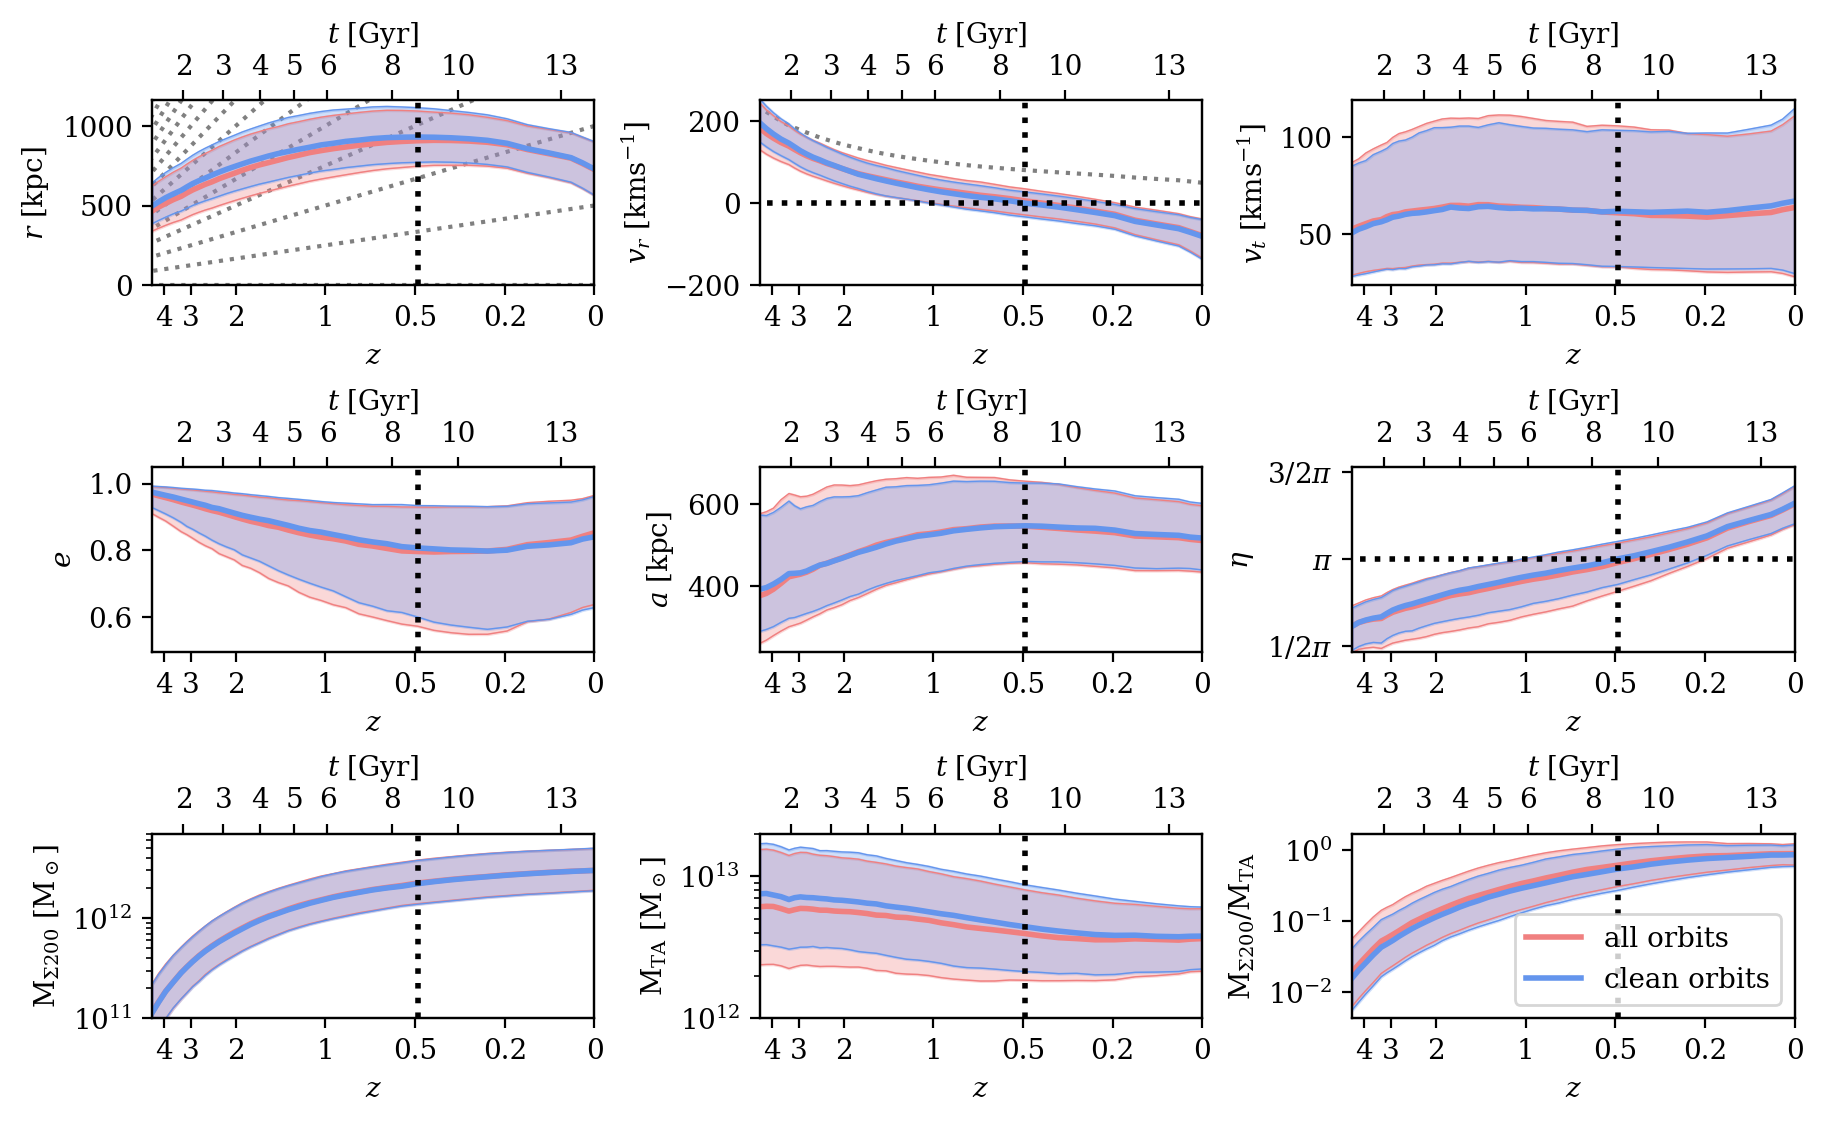

In [153]:
mask_strict = few_problems

list_M_TA_s = list_M_TA[mask_strict]
list_a_TA_s = list_a_TA[mask_strict]
list_e_TA_s = list_e_TA[mask_strict]
list_eta_TA_s = list_eta_TA[mask_strict]
list_solver_TA_s = list_solver_TA[mask_strict]
list_r_s = list_r[mask_strict]
list_vr_s = list_vr[mask_strict]
list_vt_s = list_vt[mask_strict]
list_M_MW_s = list_M_MW[mask_strict]
list_M_M31_s = list_M_M31[mask_strict]
list_N_prog_s = list_N_prog[mask_strict]
selection_orbits_s = mask_strict

list_M_TA_l = list_M_TA
list_a_TA_l = list_a_TA
list_e_TA_l = list_e_TA
list_eta_TA_l = list_eta_TA
list_solver_TA_l = list_solver_TA
list_r_l = list_r
list_vr_l = list_vr
list_vt_l = list_vt
list_M_MW_l = list_M_MW
list_M_M31_l = list_M_M31
list_N_prog_l = list_N_prog
selection_orbits_l = np.arange(len(list_M_TA))

# radii:

r_med = []
r_plus1 = []
r_minus1 = []

for idx, snap in enumerate(fine_index):
    r = np.array([list_r_s[i][idx] for i in range(len(selection_orbits_s))]) * 1000.
    r_med.append(np.percentile(r,50))
    r_plus1.append(np.percentile(r,84))
    r_minus1.append(np.percentile(r,16))
        
# vr:

vr_med = []
vr_plus1 = []
vr_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vr = np.array([list_vr_s[i][idx] for i in range(len(selection_orbits_s))]) 
    vr_med.append(np.percentile(vr,50))
    vr_plus1.append(np.percentile(vr,84))
    vr_minus1.append(np.percentile(vr,16))
    
# vt:

vt_med = []
vt_plus1 = []
vt_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vt = np.array([list_vt_s[i][idx] for i in range(len(selection_orbits_s))]) 
    vt_med.append(np.percentile(vt,50))
    vt_plus1.append(np.percentile(vt,84))
    vt_minus1.append(np.percentile(vt,16))
          
# M:

M_med = []
M_plus1 = []
M_minus1 = []

for idx, snap in enumerate(fine_index):
    
    M = np.array([list_M_MW_s[i][idx] + list_M_M31_s[i][idx] for i in range(len(selection_orbits_s))]) 
    M_med.append(np.percentile(M,50))
    M_plus1.append(np.percentile(M,84))
    M_minus1.append(np.percentile(M,16))
        
# M_TA:

M_TA_med = []
M_TA_plus1 = []
M_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    M = np.array([list_M_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    M_TA_med.append(np.percentile(M,50))
    M_TA_plus1.append(np.percentile(M,84))
    M_TA_minus1.append(np.percentile(M,16))

# M by M_TA

M_by_M_TA_med = []
M_by_M_TA_plus1 = []
M_by_M_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    M = np.array([ (list_M_MW_s[i][idx] + list_M_M31_s[i][idx]) / list_M_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    M_by_M_TA_med.append(np.percentile(M,50))
    M_by_M_TA_plus1.append(np.percentile(M,84))
    M_by_M_TA_minus1.append(np.percentile(M,16))

# eccentricity, e
e_TA_med = []
e_TA_plus1 = []
e_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    e = np.array([list_e_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    e_TA_med.append(np.percentile(e,50))
    e_TA_plus1.append(np.percentile(e,84))
    e_TA_minus1.append(np.percentile(e,16))

# semimajor axis, a
a_TA_med = []
a_TA_plus1 = []
a_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    a = np.array([list_a_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    a_TA_med.append(np.percentile(a,50))
    a_TA_plus1.append(np.percentile(a,84))
    a_TA_minus1.append(np.percentile(a,16))

# phase, eta
eta_TA_med = []
eta_TA_plus1 = []
eta_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    eta = np.array([list_eta_TA_s[i][idx] for i in range(len(selection_orbits_s))]) 
    eta_TA_med.append(np.percentile(eta,50))
    eta_TA_plus1.append(np.percentile(eta,84))
    eta_TA_minus1.append(np.percentile(eta,16))
    

var_med_s = [r_med, vr_med, vt_med, e_TA_med, a_TA_med, eta_TA_med, M_med, M_TA_med, M_by_M_TA_med]
var_plus1_s = [r_plus1, vr_plus1, vt_plus1, e_TA_plus1, a_TA_plus1, eta_TA_plus1, M_plus1, M_TA_plus1, M_by_M_TA_plus1]
var_minus1_s = [r_minus1, vr_minus1, vt_minus1, e_TA_minus1, a_TA_minus1, eta_TA_minus1, M_minus1, M_TA_minus1, M_by_M_TA_minus1]



# LOOSE


# radii:

r_med = []
r_plus1 = []
r_minus1 = []

for idx, snap in enumerate(fine_index):
    
    r = np.array([list_r_l[i][idx] for i in range(len(selection_orbits_l))]) * 1000.
    r_med.append(np.percentile(r,50))
    r_plus1.append(np.percentile(r,84))
    r_minus1.append(np.percentile(r,16))
        
# vr:

vr_med = []
vr_plus1 = []
vr_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vr = np.array([list_vr_l[i][idx] for i in range(len(selection_orbits_l))]) 
    vr_med.append(np.percentile(vr,50))
    vr_plus1.append(np.percentile(vr,84))
    vr_minus1.append(np.percentile(vr,16))
       
# vt:

vt_med = []
vt_plus1 = []
vt_minus1 = []

for idx, snap in enumerate(fine_index):
    
    vt = np.array([list_vt_l[i][idx] for i in range(len(selection_orbits_l))]) 
    vt_med.append(np.percentile(vt,50))
    vt_plus1.append(np.percentile(vt,84))
    vt_minus1.append(np.percentile(vt,16))
             
# M:

M_med = []
M_plus1 = []
M_minus1 = []

for idx, snap in enumerate(fine_index):
    
    M = np.array([list_M_MW_l[i][idx] + list_M_M31_l[i][idx] for i in range(len(selection_orbits_l))]) 
    M_med.append(np.percentile(M,50))
    M_plus1.append(np.percentile(M,84))
    M_minus1.append(np.percentile(M,16))
        
# M_TA:

M_TA_med = []
M_TA_plus1 = []
M_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    M = np.array([list_M_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    M_TA_med.append(np.percentile(M,50))
    M_TA_plus1.append(np.percentile(M,84))
    M_TA_minus1.append(np.percentile(M,16))

#M / M_TA

M_by_M_TA_med = []
M_by_M_TA_plus1 = []
M_by_M_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    M = np.array([ (list_M_MW_l[i][idx] + list_M_M31_l[i][idx]) / list_M_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    M_by_M_TA_med.append(np.percentile(M,50))
    M_by_M_TA_plus1.append(np.percentile(M,84))
    M_by_M_TA_minus1.append(np.percentile(M,16))

# eccentricity, e
e_TA_med = []
e_TA_plus1 = []
e_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    e = np.array([list_e_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    e_TA_med.append(np.percentile(e,50))
    e_TA_plus1.append(np.percentile(e,84))
    e_TA_minus1.append(np.percentile(e,16))

# semimajor axis, a
a_TA_med = []
a_TA_plus1 = []
a_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    a = np.array([list_a_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    
    a_TA_med.append(np.percentile(a,50))
    a_TA_plus1.append(np.percentile(a,84))
    a_TA_minus1.append(np.percentile(a,16))
    
# phase, eta
eta_TA_med = []
eta_TA_plus1 = []
eta_TA_minus1 = []

for idx, snap in enumerate(fine_index):

    eta = np.array([list_eta_TA_l[i][idx] for i in range(len(selection_orbits_l))]) 
    eta_TA_med.append(np.percentile(eta,50))
    eta_TA_plus1.append(np.percentile(eta,84))
    eta_TA_minus1.append(np.percentile(eta,16))
    

var_med_l = [r_med, vr_med, vt_med, e_TA_med, a_TA_med, eta_TA_med, M_med, M_TA_med, M_by_M_TA_med]
var_plus1_l = [r_plus1, vr_plus1, vt_plus1, e_TA_plus1, a_TA_plus1, eta_TA_plus1, M_plus1, M_TA_plus1, M_by_M_TA_plus1]
var_minus1_l = [r_minus1, vr_minus1, vt_minus1, e_TA_minus1, a_TA_minus1, eta_TA_minus1, M_minus1, M_TA_minus1, M_by_M_TA_minus1]



# plotting
        
fig, axes = plt.subplots(figsize=(9,5.5), ncols=3, nrows=3, dpi=200, constrained_layout = True)
norm = plt.Normalize(0,1)


for i, ax in enumerate(fig.axes):
    
    ax.fill_between(scale[fine_index], var_minus1_l[i], var_plus1_l[i], color='lightcoral', alpha=.3)
    ax.fill_between(scale[fine_index], var_minus1_s[i], var_plus1_s[i], color='cornflowerblue', alpha=.3)
    
    ax.plot(scale[fine_index], var_med_l[i], c='lightcoral', lw=2., ls='solid', zorder=2, label = 'all orbits')
    ax.plot(scale[fine_index], var_plus1_l[i], c='lightcoral', lw=.5, ls='solid', zorder=2)
    ax.plot(scale[fine_index], var_minus1_l[i], c='lightcoral', lw=.5, ls='solid', zorder=2)

    ax.plot(scale[fine_index], var_med_s[i], c='cornflowerblue', lw=2., ls='solid', zorder=2, label = 'clean orbits')
    ax.plot(scale[fine_index], var_plus1_s[i], c='cornflowerblue', lw=.5, ls='solid', zorder=2)
    ax.plot(scale[fine_index], var_minus1_s[i], c='cornflowerblue', lw=.5, ls='solid', zorder=2)

# Format and label the axes

for i, ax in enumerate(fig.axes):
        
    ax.axvline(scale[10], ls='dotted', c='black', lw=2)

    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    
    ax.set_xlabel(r'$z$')

    ax2 = ax.twiny() # ax1 and ax2 share y-axis
    ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])
    ax.set_xlim(min(scale[fine_index]),1)
    ax2.set_xlim(min(scale[fine_index]),1)

axes[0,1].plot([0,1],[0,0], ls='dotted', c='black', lw=2)

axes[0,0].set_ylim(bottom=0)
axes[2,0].set_ylim(bottom = 1e11, top=7e12)
axes[2,1].set_ylim(bottom = 1e12, top=2e13)

axes[0,0].set_ylabel(r'$r \ [\mathrm{kpc}]$')
axes[0,1].set_ylabel(r'$v_r \ [\mathrm{kms^{-1}}]$')
axes[0,2].set_ylabel(r'$v_t \ [\mathrm{kms^{-1}}]$')

axes[1,0].set_ylabel(r'$e$')
axes[1,1].set_ylabel(r'$a  \ [\mathrm{kpc}]$')
axes[1,2].set_ylabel(r'$\eta$')

axes[2,0].set_ylabel(r'$\mathrm{M_{\Sigma 200} \ [M_\odot]}$')
axes[2,1].set_ylabel(r'$\mathrm{M_{TA} \ [M_\odot]}$')
axes[2,2].set_ylabel(r'$\mathrm{M_{\Sigma 200} / M_{TA}}$')

axes[2,0].set_yscale('log')
axes[2,1].set_yscale('log')
axes[2,2].set_yscale('log')
axes[2,2].minorticks_off()


ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1])*u.Gyr
ageticks = [1 / (1 + z_at_value(cosmo.age, age)) for age in ages]

# units of pi
axes[1,2].plot([0,1],[3.1415,3.1415], ls='dotted', c='black', lw=2)

axes[1,2].set_yticks(np.arange(0, 2*np.pi+0.01, np.pi/2))
#Change axis labels:
labels = ['$0$', r'$1/2 \pi$', r'$\pi$', r'$3/2\pi$', r'$2\pi$']
axes[1,2].set_yticklabels(labels)
axes[1,2].set_ylim(np.pi / 2 - .1, 3*np.pi / 2 + .1)

axes[0,2].autoscale_view(True,True,True)

# overplot expansion of the universe:
for i in range (50):
    axes[0,0].plot(scale, i*500*scale, c = 'grey', ls = 'dotted', lw=1.5, zorder=-1)
    
# for the hubble expansion speed, we use the median separation
    
Hubble_flow = cosmo.H(1/scale - 1).value # value is km/s / Mpc
axes[0,1].plot(scale[fine_index], Hubble_flow[fine_index] * r_med / 1000., c = 'grey', ls = 'dotted', lw=1.5, zorder=-1)

axes[0,1].set_ylim(-200,250)
axes[1,0].set_ylim(0.495,1.05)

axes[2,2].legend()

plt.savefig('evolution_problems.pdf')
    